## 1. Prepare data

#### Imports and Dependencies

In [ ]:
import torch

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn, optim
from datetime import datetime

#### Bring in the data

In [ ]:
import pandas as pd

# Read in AMZN historical stock data as `data`
filepath = "AMZN.csv"
dataset = pd.read_csv(filepath)
# print(dataset)

#### Clean up the data

In [ ]:
# Reorder the columns
dataset = dataset[['Open', 'High', 'Low', 'Volume', 'Close']]
# Scale down Volume to tens of millions
dataset['Volume'] = dataset['Volume'] / 10000000

# dataset = dataset.to_numpy()
# np.set_printoptions(suppress=True)
# print(dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Split `Data` into Training, Test, Validation and Create Sequences
Each sequence in for x is connected to a resulting y.
<br>
The value for sequence is currently set to 20, and should be adjusted to test the effects.

In [ ]:
# # function to create train, validation, test data given stock data and sequence length
# def load_data(stock, seq_len):
#     data_raw = stock.values # convert to numpy array
#     data = []
    
#     # create all possible sequences of length seq_len
#     for index in range(len(data_raw) - seq_len): 
#         data.append(data_raw[index: index + seq_len])
    
#     data = np.array(data)
#     valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0])) 
#     test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
#     train_set_size = data.shape[0] - (valid_set_size + test_set_size)
    
#     x_train = data[:train_set_size,:-1,:]
#     y_train = data[:train_set_size,-1,4:] # last index (4:) makes it so we only take the 'Close' column
    
#     x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
#     y_valid = data[train_set_size:train_set_size+valid_set_size,-1,4:]
    
#     x_test = data[train_set_size+valid_set_size:,:-1,:]
#     y_test = data[train_set_size+valid_set_size:,-1,4:]
    
#     return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# # split data in 80%/10%/10% train/validation/test sets
# valid_set_size_percentage = 10 
# test_set_size_percentage = 10

# # create train, test data
# seq_length = 20 # choose sequence length
# x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(dataset, seq_length)

# # y_train = np.squeeze(y_train)
# # y_valid = np.squeeze(y_valid)
# # y_test = np.squeeze(y_test)

# # convert sequence to dataframe
# def convert_sequence_to_dataframe(array):
#     m,n,r = array.shape
#     out_arr = np.column_stack((np.repeat(np.arange(m),n),array.reshape(m*n,-1)))
#     out_df = pd.DataFrame(out_arr, columns=['Sequence', 'Open', 'High', 'Low', 'Volume', 'Close'])
#     return out_df

# # print(x_train)  
# # x_train = convert_sequence_to_dataframe(x_train)
# # y_train = pd.DataFrame(y_train, columns=['Close'])
# # x_valid = convert_sequence_to_dataframe(x_valid)
# # y_valid = pd.DataFrame(y_valid, columns=['Open', 'High', 'Low', 'Volume', 'Close'])
# # x_test = convert_sequence_to_dataframe(x_test)
# # y_test = pd.DataFrame(y_test, columns=['Open', 'High', 'Low', 'Volume', 'Close'])

#### Printing Methods

In [ ]:
def print_datasets():
    print(x_train)
    print(y_train)
    print(x_valid)
    print(y_valid)
    print(x_test)
    print(y_test)

def print_shapes():
    print('x_train.shape = ', x_train.shape)
    print('y_train.shape = ', y_train.shape)
    print('x_valid.shape = ', x_valid.shape)
    print('y_valid.shape = ', y_valid.shape)
    print('x_test.shape = ', x_test.shape)
    print('y_test.shape = ', y_test.shape)

# print_shapes()
# print_datasets()

### Split `Data` into Training, Test, Validation and Create Sequences

In [ ]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    x = df.drop(columns=[target_col])
    return x, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    x, y = feature_label_split(df, target_col)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_ratio, shuffle=False)
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(dataset, 'Close', 0.2)

#### Printing Methods

In [ ]:
def print_datasets():
    print(x_train)
    print(y_train)
    print(x_val)
    print(y_val)
    print(x_test)
    print(y_test)

def print_shapes():
    print('x_train.shape = ', x_train.shape)
    print('y_train.shape = ', y_train.shape)
    print('x_val.shape = ', x_val.shape)
    print('y_val.shape = ', y_val.shape)
    print('x_test.shape = ', x_test.shape)
    print('y_test.shape = ', y_test.shape)

print_shapes()
# print_datasets()

x_train.shape =  (3690, 4)
y_train.shape =  (3690, 1)
x_val.shape =  (1230, 4)
y_val.shape =  (1230, 1)
x_test.shape =  (1230, 4)
y_test.shape =  (1230, 1)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 500

train_features = torch.Tensor(x_train.to_numpy())
train_targets = torch.Tensor(y_train.to_numpy())
val_features = torch.Tensor(x_val.to_numpy())
val_targets = torch.Tensor(y_val.to_numpy())
test_features = torch.Tensor(x_test.to_numpy())
test_targets = torch.Tensor(y_test.to_numpy())

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

## 2. Define the Model

#### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

#### GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

#### Switch between models

In [ ]:
def get_model(model, model_params):
    models = {
        # "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

## 3. Train the Model

##### Optimization Class

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().cpu().clone().numpy())
                values.append(y_test.to(device).detach().cpu().clone().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

#### Start actually training

[1/1000] Training loss: 4395.1999	 Validation loss: 123865.4805
[2/1000] Training loss: 4365.0202	 Validation loss: 123652.8125
[3/1000] Training loss: 4321.5737	 Validation loss: 123298.7070
[4/1000] Training loss: 4260.1907	 Validation loss: 122832.5977
[5/1000] Training loss: 4175.8956	 Validation loss: 122235.7930
[6/1000] Training loss: 4071.4507	 Validation loss: 121463.3281
[7/1000] Training loss: 3961.1837	 Validation loss: 120728.3984
[8/1000] Training loss: 3855.0534	 Validation loss: 120045.2930
[9/1000] Training loss: 3768.4590	 Validation loss: 119495.6875
[10/1000] Training loss: 3694.9692	 Validation loss: 119012.0312
[50/1000] Training loss: 2494.6695	 Validation loss: 109294.4629
[100/1000] Training loss: 1753.8929	 Validation loss: 101148.2578
[150/1000] Training loss: 1321.0585	 Validation loss: 94937.4746
[200/1000] Training loss: 1039.4315	 Validation loss: 89863.4238
[250/1000] Training loss: 833.5779	 Validation loss: 85468.9043
[300/1000] Training loss: 677.4973

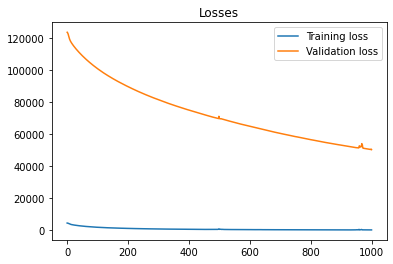

In [ ]:
import torch.optim as optim

input_dim = len(x_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
# batch_size = 4032
dropout = 0.2
n_epochs = 1000
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('gru', model_params)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)